# Assignment 3

**Submission deadlines:**
- deadline: last lab session Tuesday, 09.04.2023

**Points:** Aim to get 8 points + 2 extra

## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

For the problem 2, we provide the starter code,
however, you are not required to use it as long as you properly solve the tasks.

# Problem 1: Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flowers102` class. You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flowers102(root='./data', download=True, transform=transforms.ToTensor())
```

In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1.1 **[2p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    * Train your CNN on a small part of the dataset (e.g., 10%, 25%, 50%, 75%, 100% of the original training set) while keeping the validation and test sets constant.

* 1.2 **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 1.3 **[1p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 1.4 **[1p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.

* 1.5 **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 1.6 ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

You can use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.




In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
import wandb

In [2]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
        augmentation=False
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)

        #for b in batches:
        #    print("BATCH\n")
        #    for x in b:
        #        print(x.shape)
        
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.augmentation = augmentation

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        if self.augmentation:
            applier = v2.RandomApply(transforms=[v2.RandomRotation(degrees=(-180, 180)), v2.RandomResizedCrop(size=(256, 256), scale=(0.6, 1.0)), v2.RandomHorizontalFlip(p=0.5), v2.RandomVerticalFlip(p=0.5)], p=0.5)
            for batch_indices in self.batch_sampler:
                yield applier(self.dataset[batch_indices])
                
        else:
            for batch_indices in self.batch_sampler:
                yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [3]:
# Load the data
datatransforms = {}
datatransforms["train"] = v2.Compose( [v2.Resize(size=(256, 256)), v2.ToTensor()] )
datatransforms["val"] = v2.Compose( [v2.Resize(size=(256, 256)), v2.ToTensor()] )
datatransforms["test"] = v2.Compose( [v2.Resize(size=(256, 256)), v2.ToTensor()] )

_train = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=datatransforms["train"])
_valid = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=datatransforms["val"])
_test = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=datatransforms["test"])

flower_loaders16 = {
    "train": InMemDataLoader(_train, batch_size=16, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=16, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=16, shuffle=False),
}

flower_loaders32 = {
    "train": InMemDataLoader(_train, batch_size=32, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=32, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=32, shuffle=False),
}

#flower_loaders64 = {
#    "train": InMemDataLoader(_train, batch_size=64, shuffle=True),
#    "valid": InMemDataLoader(_valid, batch_size=64, shuffle=False),
#    "test": InMemDataLoader(_test, batch_size=64, shuffle=False),
#}

/home/szymon/pythonvenvs/rocmwork/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


  0%|          | 0/1020 [00:00<?, ?it/s]

/tmp/ipykernel_5334/3656887412.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/6149 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/6149 [00:00<?, ?it/s]

In [4]:
def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    #plt.ylim(0, 0.20)
    plt.legend()

In [5]:
def compute_error_rate(model, data_loader, device):
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)
        
    num_errs = 0.0
    num_examples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples

def train(model, data_loaders, batch_size, learning_rate=0.01, momentum=0.0, epochs=100, log_every=100, train_percentage=1.0, optimizer_name="SGD", wandblogging=False, device="cpu"):
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)
            
    optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), learning_rate)
        
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    best_params = None
    best_valid_err = np.inf
    iter_ = 0
    tstart = time.time()
    
    for epoch in range(epochs):
        model.train()

        xyiter = 0
        for x, y in data_loaders["train"]:
            if (xyiter * batch_size) / 1020.0 > train_percentage:
                break
            xyiter += 1
            
            x = x.to(device)
            y = y.to(device)

            #print(f"x shape:{x.shape}")
            
            pred = model(x)
            loss = model.loss(pred, y)

            _, predictions = pred.max(dim=1)
            batch_err_rate = (predictions != y).sum().item() / pred.size(0)
            history["train_losses"].append(loss.item())
            history["train_errs"].append(batch_err_rate)
            if wandblogging:
                wandb.log({"train_error_rate" : batch_err_rate})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iter_ += 1
            if log_every != -1 and iter_ % log_every == 0:
                num_iter = iter_
                print(
                    "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                        iter_,
                        loss.item(),
                        batch_err_rate * 100.0,
                        num_iter / (time.time() - tstart),
                    )
                )
                tstart = time.time()

        valid_err_rate = compute_error_rate(model, data_loaders["valid"], device)
        
        history["val_errs"].append((iter_, valid_err_rate))
        if wandblogging:
            wandb.log({"valid_error_rate" : valid_err_rate})

        if valid_err_rate < best_valid_err:
            best_epoch = epoch
            best_valid_err = valid_err_rate
            best_params = [p.detach().cpu() for p in model.parameters()]
            
        #clear_output(True)
        m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
            epoch, valid_err_rate * 100.0, epochs
        )
        #print("{0}\n{1}\n{0}".format("-" * len(m), m))

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param


    #print("history[train loss] length:" + str(len(history["train_losses"])) + str(history["train_losses"]))
    #print("history[train errs] shape:" + str(len(history["train_errs"])) + str(history["train_errs"]))
    #print("history[val errs] shape:" + str(len(history["val_errs"])) + str(history["val_errs"]))
    return history
        

In [6]:
class ModelConv(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ModelConv, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 32, 3, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(3,2),
                                    nn.Conv2d(32, 64, 3, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(3,2),
                                    nn.Conv2d(64, 128, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(3,2),
                                    nn.Flatten(),
                                    nn.Linear(4608, 1000),
                                    nn.ReLU(),
                                    nn.Linear(1000, 204),
                                    nn.ReLU(),
                                    nn.Linear(204, 102))

    def forward(self, X):
        X = X.view(X.size(0), 3, 256, 256)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

def trainonparams(model, data_loaders, batch_size, lr, momentum_, epochs_, log_every_, train_percentage_, optimizer_name_, experiment_name, wandblogging_=False):
    hyperparameters = {
        "batch_size" : batch_size,
        "learning_rate" : lr,
        "momentum" : momentum_,
        "epochs": epochs_,
        "train_percentage" : train_percentage_,
        "optimizer_name" : optimizer_name_
    }
    #log_every_ = -1
    
    # Initialize parameters
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.0)

    model.layers.apply(init_weights)
    
    #with torch.no_grad():
    #    for name, p in model.named_parameters():
    #        print(f"parameter: {p}, name:{name}")
    #        if "weight" in name:
    #            nn.init.xavier_normal_(p)
    #        elif "bias" in name:
    #            p.zero_()
    #        else:
    #            raise ValueError('Unknown parameter name "%s"' % name)

    t_start = time.time()
    if wandblogging_ == False:
        train_history = train(model, data_loaders, batch_size, learning_rate=lr, momentum=momentum_, epochs=epochs_, log_every=log_every_, train_percentage=train_percentage_, optimizer_name=optimizer_name_, wandblogging=wandblogging_, device="cuda")
        
        test_err_rate = compute_error_rate(model, data_loaders["test"], device="cuda")
        m = (
            f"Test error rate: {test_err_rate * 100.0:.3f}%, "
            f"training took {time.time() - t_start:.0f}s."
        )
        print("{0}\n{1}\n{0}".format("-" * len(m), m))
        plot_history(train_history)
    else:
        with wandb.init(project=experiment_name, config=hyperparameters):
            wandb.run.name = "flowers "
            for (k, v) in hyperparameters.items():
                wandb.run.name += ", " + str(v)
                
            train_history = train(model, data_loaders, batch_size, learning_rate=lr, momentum=momentum_, epochs=epochs_, log_every=log_every_, train_percentage=train_percentage_, optimizer_name=optimizer_name_, wandblogging=wandblogging_, device="cuda")
            
            test_err_rate = compute_error_rate(model, data_loaders["test"], device="cuda")
            m = (
                f"Test error rate: {test_err_rate * 100.0:.3f}%, "
                f"training took {time.time() - t_start:.0f}s."
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
            plot_history(train_history)
            wandb.log({"test_error_rate" : test_err_rate})



In [7]:
modelConv = ModelConv()

In [8]:
def experiment(model, data_loaders, batch_size, lrlist, momentumlist, epochlist, trainpercentlist, optimizernamelist, experiment_name):
    for learning_rate in lrlist:
        for momentum in momentumlist:
            for train_percentage in trainpercentlist:
                for epochs in epochlist:
                    for optimizer_name in optimizernamelist:
                        trainonparams(model, data_loaders, batch_size, learning_rate, momentum, epochs, -1, train_percentage, optimizer_name, experiment_name, True)


Task 1.1

In [9]:
def experiment1(data_loaders, batch_size):
    lrlist = [0.01]
    momentumlist = [0.0001]
    trainpercentlist = [0.1, 0.25, 0.5, 0.75, 1.0]

    experiment(modelConv, data_loaders, batch_size, lrlist, momentumlist, [200], trainpercentlist, ["SGD"], "flowers_task_1")
               
#experiment1(flower_loaders32, 32)
#experiment1(flower_loaders16, 16)

Task 1.2

In [10]:
datatransforms = {}
_train = 0
_valid = 0
_test = 0
flower_loaders16 = 0
flower_loaders32 = 0

In [11]:
# Load the data, this time with normalization

datatransforms = {}
datatransforms["train"] = v2.Compose( [v2.Resize(size=(256, 256)), v2.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] )
datatransforms["val"] = v2.Compose( [v2.Resize(size=(256, 256)), v2.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] )
datatransforms["test"] = v2.Compose( [v2.Resize(size=(256, 256)), v2.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] )

#SWAPPED!!!!!!!!!
_train = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=datatransforms["train"])
_valid = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=datatransforms["val"])
_test = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=datatransforms["test"])

#flower_loaders16 = {
#    "train": InMemDataLoader(_test, batch_size=16, shuffle=True),
#    "valid": InMemDataLoader(_valid, batch_size=16, shuffle=False),
#    "test": InMemDataLoader(_train, batch_size=16, shuffle=False),
#}

flower_loaders32 = {
    "train": InMemDataLoader(_test, batch_size=32, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=32, shuffle=False),
    "test": InMemDataLoader(_train, batch_size=32, shuffle=False),
}

/home/szymon/pythonvenvs/rocmwork/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


  0%|          | 0/6149 [00:00<?, ?it/s]

/tmp/ipykernel_5334/3656887412.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

In [12]:
def experiment2(data_loaders, batch_size):
    lrlist = [0.01]
    momentumlist = [0.0001]
    trainpercentlist = [0.1, 0.25, 0.5, 0.75, 1.0]

    experiment(modelConv, data_loaders, batch_size, lrlist, momentumlist, [200], trainpercentlist, ["SGD"], "flowers_task_2_swapped")

#experiment2(flower_loaders32, 32)
#experiment2(flower_loaders16, 16)

Task 1.3

In [13]:
def experiment3(data_loaders, batch_size):
    lrlist = [0.01, 0.005]
    momentumlist = [0.001, 0.0001]
    trainpercentlist = [0.75, 1.0]
    epochlist = [100, 200]
    optimizernamelist = ["SGD"]

    experiment(modelConv, data_loaders, batch_size, lrlist, momentumlist, epochlist, trainpercentlist, optimizernamelist, "flowers_task_3_swapped")

#experiment3(flower_loaders32, 32)
#experiment3(flower_loaders16, 16)

Task 1.4

In [14]:
class ModelConv2(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ModelConv2, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 16, 3),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.2),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(16, 32, 3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.2),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.2),
                                    nn.MaxPool2d(2,2),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(57600, 4080),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    #nn.Linear(4080, 1020),
                                    #nn.ReLU(),
                                    #nn.Dropout(0.2),
                                    nn.Linear(4080, 102))

    def forward(self, X):
        X = X.view(X.size(0), 3, 256, 256)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

modelConv2 = ModelConv2()


Loading best params on validation set (epoch 143)

---------------------------------------------
Test error rate: 65.196%, training took 487s.
---------------------------------------------


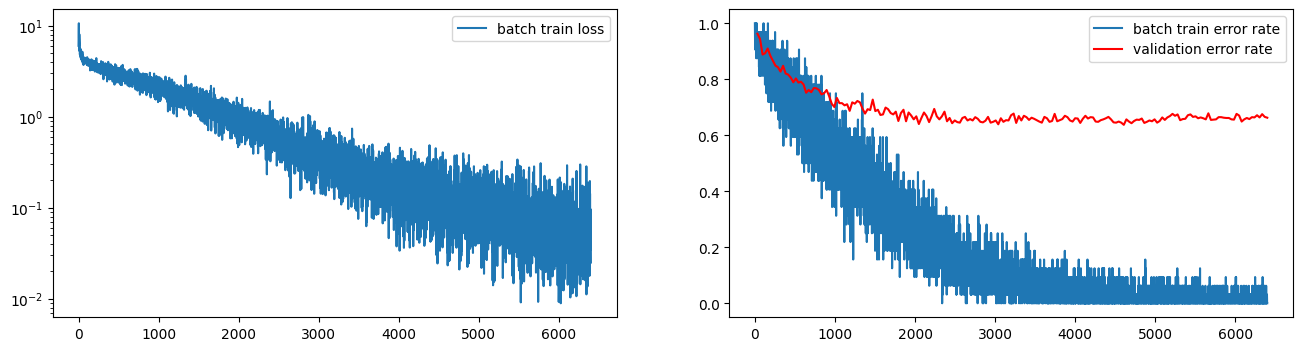

In [21]:
#trainonparams(modelConv2, flower_loaders32, 32, 0.005, 0.0001, 200, -1, 1, "SGD", "")

In [17]:
def experiment4(data_loaders, batch_size):
    lrlist = [0.01, 0.005]
    momentumlist = [0.001]
    trainpercentlist = [0.75, 1.0]
    epochlist = [200]
    optimizernamelist = ["SGD"]

    experiment(modelConv2, data_loaders, batch_size, lrlist, momentumlist, epochlist, trainpercentlist, optimizernamelist, "flowers_task_4_swapped")

#experiment4(flower_loaders32, 32)

In [15]:
flower_loaders32 = {
    "train": InMemDataLoader(_test, batch_size=32, shuffle=True, augmentation=True),
    "valid": InMemDataLoader(_valid, batch_size=32, shuffle=False),
    "test": InMemDataLoader(_train, batch_size=32, shuffle=False),
}

  0%|          | 0/6149 [00:00<?, ?it/s]

/tmp/ipykernel_5334/3656887412.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

In [23]:
def experiment5(data_loaders, batch_size):
    lrlist = [0.05]
    momentumlist = [0.0001]
    trainpercentlist = [1.0]
    epochlist = [1000]
    optimizernamelist = ["SGD"]

    experiment(modelConv2, data_loaders, batch_size, lrlist, momentumlist, epochlist, trainpercentlist, optimizernamelist, "flowers_task_5_swapped")

#experiment5(flower_loaders32, 32)


Loading best params on validation set (epoch 334)

---------------------------------------------
Test error rate: 50.392%, training took 989s.
---------------------------------------------


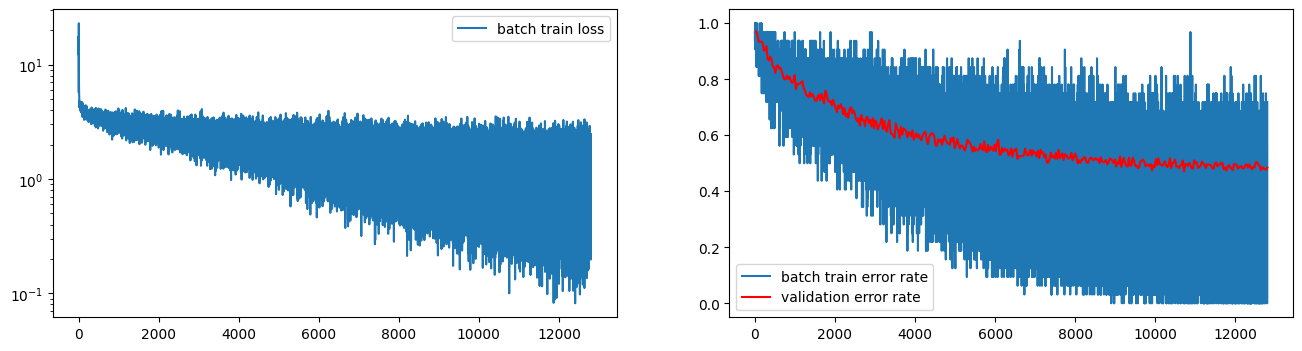

In [16]:
trainonparams(modelConv2, flower_loaders32, 32, 0.01, 0.0001, 400, -1, 1, "SGD", "")


Loading best params on validation set (epoch 585)

----------------------------------------------
Test error rate: 41.961%, training took 1435s.
----------------------------------------------


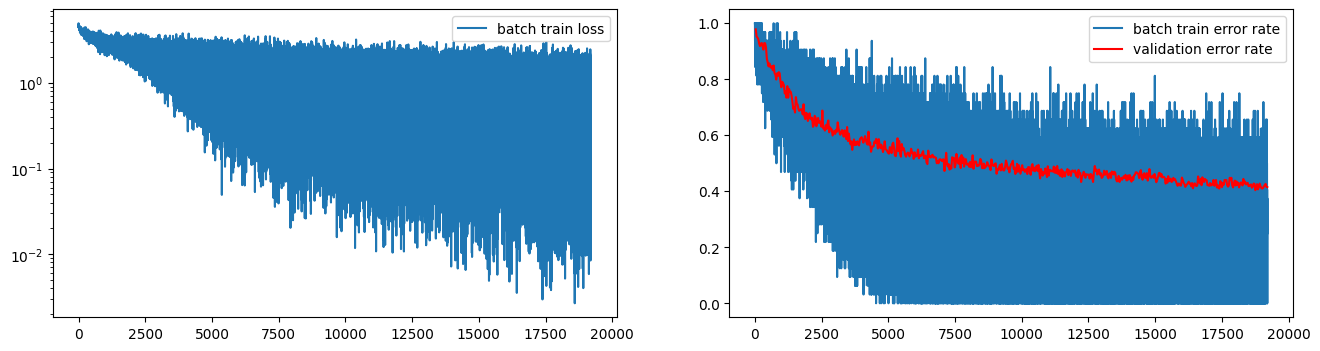

In [21]:
trainonparams(modelConv2, flower_loaders32, 32, 0.05, 0.0001, 600, -1, 1, "SGD", "")

# Problem 2: Reusing a VGG Network [2p]

Training large-scale models takes much time and resources. It also requires caution when picking hyperparameters. It is a common practice to share learned parameters of large models, and reuse them in different tasks. Weight matrices can be shared, even between entirely different frameworks. Further reading: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792) by Yosinski et al.

Neural networks trained for image classification might be seen as composed of two elements: a feature extractor, and a classifier. The former is typically made of a stack of convolutional layers, while the latter is the last linear layer of the model.

We will focus on the deepest models - VGG16 and/or VGG19. To complete the task, load pre-trained VGG model. Then:
1. **[1p]** Train the classifier part of the network on the
  [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset of images:
  * replace the classifier with a new randomly initialized one, whose output dimensionality matches
    the number of classes of the Caltech101 dataset. You can replace all layers in the classifier
    part of the VGG with just one affine projection into 102 classes.
  * to significantly reduce training time and avoid destroying network weights early in the training,
    train only the weights of the classifier. You can achieve this by applying the optimization only
    to the classifier's parameters.
    
2. **[1p]** Assess the usefulness of using dropout and data augmentation during classifier training.
  
This procedure should quickly give you less than 10% training errors on the Caltech101 dataset!

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
import wandb

## Starter Code

In [2]:
#vgg = VGG("vgg19")
vgg = torchvision.models.vgg19_bn(weights='DEFAULT')
vgg.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [3]:
# List layers in the model
print("Feature layers")
print("--------------")
#for name, layer in zip(vgg.feature_names, vgg.features):
#    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------

Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=1000, bias=True)


In [4]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform

    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indexes)

In [5]:
#![ -d 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
![ -e 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

In [6]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("./101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [7]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

(20, 3, 224, 224)


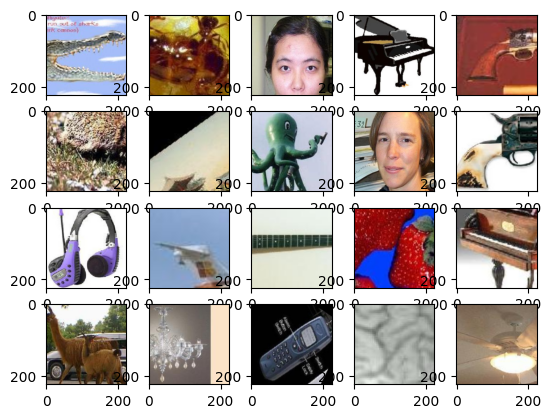

In [8]:
train_batch = next(iter(caltech_loaders["train"]))
#common.plotting.plot_mat(to_np(train_batch[0])[:20])
#print(train_batch[0].numpy()[:20][0].transpose((1, 2, 0)).shape)
data_to_show = train_batch[0].numpy()[:20]
print(data_to_show.shape)
f, axarr = plt.subplots(4, 5)
for i in range(4):
    for j in range(5):
        axarr[i, j].imshow(data_to_show[i * 5 + j].transpose((1, 2, 0)))

In [9]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=1000, bias=True)


In [10]:
# Train only the classifier!
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, data_loaders, optimizer, criterion, num_epochs=1, log_every=100, cuda=True
):
    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders["train"]:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1

                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())


                if iter_ % log_every == 0:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:


                best_epoch = epoch
                best_val_err = val_err_rate


            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        model.parameters = best_params
    plot_history(history)


def plot_history(history):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    #plt.ylim(0, 0.20)
    plt.legend()

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  1.30 | err rate 31.25%
Minibatch    100  | loss  1.28 | err rate 32.81%
----------------------------------------------------------
After epoch  1 | valid err rate: 12.63% | doing  15 epochs
----------------------------------------------------------
Minibatch    150  | loss  1.03 | err rate 23.44%
Minibatch    200  | loss  0.65 | err rate 17.19%
----------------------------------------------------------
After epoch  2 | valid err rate: 11.54% | doing  15 epochs
----------------------------------------------------------
Minibatch    250  | loss  0.80 | err rate 21.88%
Minibatch    300  | loss  0.58 | err rate 17.19%
----------------------------------------------------------
After epoch  3 | valid err rate: 10.77% | doing  15 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.66 | err rate 17.19%
Minibatch    400  | loss  0.55 | err rate 15.62%
Minibatch    450  | los

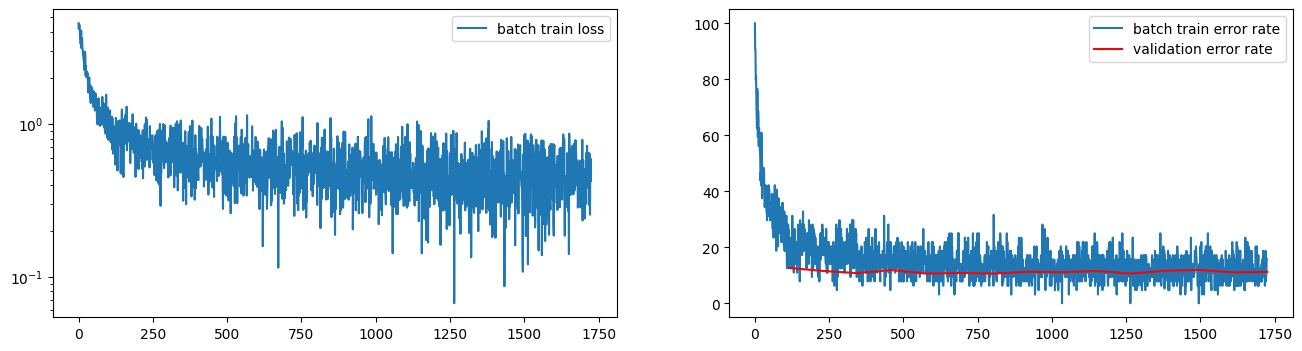

In [11]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`

#classifier1 = torch.nn.Sequential(torch.nn.Linear(25088, 4096), torch.nn.Linear(4096, 101))
classifier1 = torch.nn.Linear(25088, 101)

# Replace the classifier of our VGG network
vgg.classifier = classifier1

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
#optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0005) #, eps=0.01, weight_decay=0.0)

t_start = time.time()
train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=15, log_every=50, cuda=True
)
print(f"training took {time.time() - t_start:.0f}s.")

Task 2

In [12]:
# augmenting training dataset:

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(size=(224,224), scale=(0.3, 1.0)),
            torchvision.transforms.RandomRotation(degrees=(-180, 180)),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.RandomVerticalFlip(p=0.5),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  4.11 | err rate 92.19%
Minibatch    100  | loss  4.21 | err rate 82.81%
----------------------------------------------------------
After epoch  1 | valid err rate: 75.89% | doing  20 epochs
----------------------------------------------------------
Minibatch    150  | loss  3.59 | err rate 73.44%
Minibatch    200  | loss  3.48 | err rate 71.88%
----------------------------------------------------------
After epoch  2 | valid err rate: 66.76% | doing  20 epochs
----------------------------------------------------------
Minibatch    250  | loss  2.97 | err rate 65.62%
Minibatch    300  | loss  3.08 | err rate 70.31%
----------------------------------------------------------
After epoch  3 | valid err rate: 57.85% | doing  20 epochs
----------------------------------------------------------
Minibatch    350  | loss  2.57 | err rate 51.56%
Minibatch    400  | loss  3.24 | err rate 75.00%
Minibatch    450  | los

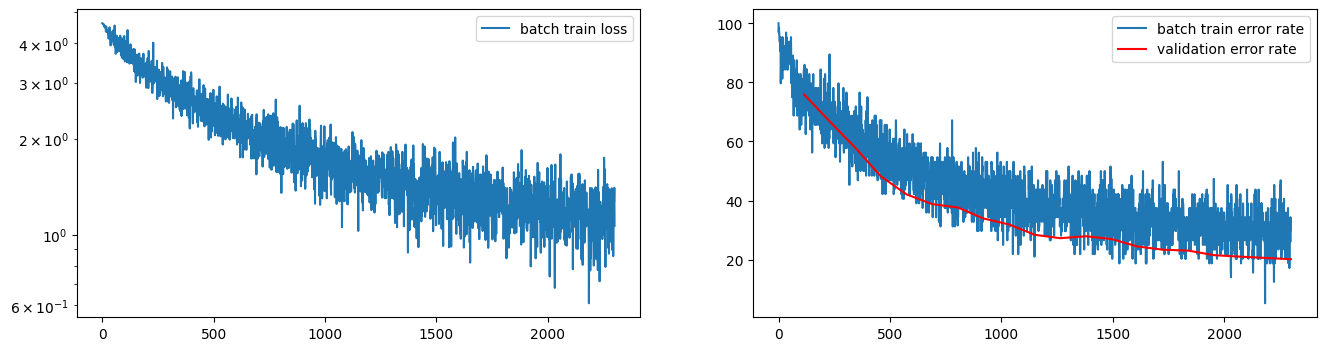

In [13]:
classifier2 = torch.nn.Sequential(nn.Linear(25088, 8192),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(8192, 4096),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(4096, 101))

vgg.classifier = classifier2

for p in vgg.parameters():
    p.requires_grad = False

for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)

optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.00001)

t_start = time.time()
train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=20, log_every=50, cuda=True
)
print(f"training took {time.time() - t_start:.0f}s.")